In [1]:
import random
import torch
import pickle
import os
import matplotlib.pyplot as plt

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *
from causal_rl.algo.imitation.finetune import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_steps = 1000
seed = 0
hidden_dims = {'O'}
lookback = 1
train_eps = 1000

random.seed(seed)
torch.manual_seed(seed)

In [ ]:
expert_env = AntMazePCH(num_steps=num_steps, hidden_dims=set(), seed=seed)

In [ ]:
env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed)

In [ ]:
# to save time; conceptually the same
small_steps = lookback + 1
small_env = AntMazePCH(num_steps=small_steps, hidden_dims=hidden_dims, seed=seed)
G = parse_graph(small_env.get_graph)
X_small = {f'X{t}' for t in range(small_steps)}
Y = f'Y{small_steps}'

# G = parse_graph(env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
# Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [ ]:
Z_sets = find_sequential_pi_backdoor(G, X_small, Y, obs_prefix)

base_step = small_steps - 1
base_Z_set = Z_sets[f'X{base_step}']

for i in range(base_step + 1, num_steps):
    updated_base_Z_set = set()
    for v in base_Z_set:
        updated_base_Z_set.add(f'{v[0]}{int(v[1:]) + i - lookback}')

    Z_sets[f'X{i}'] = updated_base_Z_set

Z_sets['X1']

{'A0', 'A1', 'J0', 'J1', 'L0', 'L1', 'P0', 'P1', 'T0', 'T1', 'X0'}

In [ ]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

naive_Z_sets['X1']

{'A0', 'A1', 'J0', 'J1', 'L0', 'L1', 'P0', 'P1', 'T0', 'T1', 'W0', 'W1', 'X0'}

In [ ]:
# load expert
MODEL_PATH = '/home/et2842/causal/causalrl/models/antmaze_expert_finetuned.pt'
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

expert = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

expert.load_state_dict(checkpoint['state_dict'])
expert.eval()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

expert_policy = shared_policy_fn_long_horizon(expert, slots, Z_trim, continuous=True, device=device)
expert_policies = make_shared_policy_dict(expert_policy)

In [ ]:
records = collect_imitator_trajectories(
    expert_env,
    expert_policies,
    num_episodes=train_eps,
    max_steps=num_steps,
    seed=seed,
    hidden_dims=hidden_dims,
    show_progress=True
)

Starting episode 1/1000...
  Episode 1 ended at step 273 (terminated: True, truncated: False).
Starting episode 2/1000...
  Episode 2 ended at step 264 (terminated: True, truncated: False).
Starting episode 3/1000...
  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/1000...
  Episode 4 ended at step 267 (terminated: True, truncated: False).
Starting episode 5/1000...
  Episode 5 ended at step 228 (terminated: True, truncated: False).
Starting episode 6/1000...
  Episode 6 ended at step 290 (terminated: True, truncated: False).
Starting episode 7/1000...
  Episode 7 ended at step 214 (terminated: True, truncated: False).
Starting episode 8/1000...


  Episode 8 ended at step 263 (terminated: True, truncated: False).
Starting episode 9/1000...
  Episode 9 ended at step 228 (terminated: True, truncated: False).
Starting episode 10/1000...


KeyboardInterrupt: 

In [ ]:
# with open('/home/et2842/causal/expert_traj.pkl', 'wb') as f:
#     pickle.dump(records, f)

# print(f'saved {len(records)} trajectories')

In [ ]:
# with open('/home/et2842/causal/expert_traj.pkl', 'rb') as f:
#     records = pickle.load(f)

# print(f'loaded {len(records)} trajectories')

In [ ]:
hidden_size = 256
lr = 3e-4
batch_size = 2048
patience = 15
num_blocks = 4
epochs = 100
dropout = 0.0

dims = {
    'P': 3,
    # 'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    'W': 2,
    'X': 8
}

In [ ]:
causal_model, causal_slots, causal_Z_trim = train_single_policy_long_horizon(
    records,
    Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

causal_policy = shared_policy_fn_long_horizon(causal_model, causal_slots, causal_Z_trim, continuous=True, device=device)
causal_policies = make_shared_policy_dict(causal_policy)

[LongHorizon] Epoch 1: train loss = 0.078139, val loss = 0.023628.
[LongHorizon] Epoch 2: train loss = 0.018467, val loss = 0.015370.
[LongHorizon] Epoch 3: train loss = 0.013416, val loss = 0.011965.
[LongHorizon] Epoch 4: train loss = 0.011108, val loss = 0.010588.
[LongHorizon] Epoch 5: train loss = 0.009776, val loss = 0.009677.
[LongHorizon] Epoch 6: train loss = 0.008856, val loss = 0.008747.
[LongHorizon] Epoch 7: train loss = 0.008211, val loss = 0.008260.
[LongHorizon] Epoch 8: train loss = 0.007620, val loss = 0.007820.
[LongHorizon] Epoch 9: train loss = 0.007188, val loss = 0.007499.
[LongHorizon] Epoch 10: train loss = 0.006852, val loss = 0.007232.
[LongHorizon] Epoch 11: train loss = 0.006555, val loss = 0.006894.
[LongHorizon] Epoch 12: train loss = 0.006238, val loss = 0.006673.
[LongHorizon] Epoch 13: train loss = 0.006008, val loss = 0.006622.
[LongHorizon] Epoch 14: train loss = 0.005797, val loss = 0.006631.
[LongHorizon] Epoch 15: train loss = 0.005602, val loss =

In [ ]:
naive_model, naive_slots, naive_Z_trim = train_single_policy_long_horizon(
    records,
    naive_Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

naive_policy = shared_policy_fn_long_horizon(naive_model, naive_slots, naive_Z_trim, continuous=True, device=device)
naive_policies = make_shared_policy_dict(naive_policy)

[LongHorizon] Epoch 1: train loss = 0.085559, val loss = 0.026971.
[LongHorizon] Epoch 2: train loss = 0.020445, val loss = 0.016590.
[LongHorizon] Epoch 3: train loss = 0.014422, val loss = 0.013936.
[LongHorizon] Epoch 4: train loss = 0.011846, val loss = 0.012943.
[LongHorizon] Epoch 5: train loss = 0.010432, val loss = 0.011035.
[LongHorizon] Epoch 6: train loss = 0.009376, val loss = 0.010192.
[LongHorizon] Epoch 7: train loss = 0.008654, val loss = 0.010278.
[LongHorizon] Epoch 8: train loss = 0.008088, val loss = 0.010346.
[LongHorizon] Epoch 9: train loss = 0.007650, val loss = 0.008105.
[LongHorizon] Epoch 10: train loss = 0.007156, val loss = 0.008247.
[LongHorizon] Epoch 11: train loss = 0.006860, val loss = 0.007659.
[LongHorizon] Epoch 12: train loss = 0.006560, val loss = 0.007798.
[LongHorizon] Epoch 13: train loss = 0.006345, val loss = 0.006964.
[LongHorizon] Epoch 14: train loss = 0.006036, val loss = 0.008163.
[LongHorizon] Epoch 15: train loss = 0.005957, val loss =

Starting episode 1/1000...
  Episode 1 ended at step 277 (terminated: True, truncated: False).
Starting episode 2/1000...
  Episode 2 ended at step 205 (terminated: True, truncated: False).
Starting episode 3/1000...
  Episode 3 ended at step 265 (terminated: True, truncated: False).
Starting episode 4/1000...
  Episode 4 ended at step 267 (terminated: True, truncated: False).
Starting episode 5/1000...
  Episode 5 ended at step 267 (terminated: True, truncated: False).
Starting episode 6/1000...
  Episode 6 ended at step 208 (terminated: True, truncated: False).
Starting episode 7/1000...


  Episode 7 ended at step 222 (terminated: True, truncated: False).
Starting episode 8/1000...
  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/1000...
  Episode 9 ended at step 255 (terminated: True, truncated: False).
Starting episode 10/1000...
  Episode 10 ended at step 236 (terminated: True, truncated: False).
Starting episode 11/1000...
  Episode 11 ended at step 269 (terminated: True, truncated: False).
Starting episode 12/1000...
  Episode 12 ended at step 235 (terminated: True, truncated: False).
Starting episode 13/1000...
  Episode 13 ended at step 273 (terminated: True, truncated: False).
Starting episode 14/1000...
  Episode 14 ended at step 283 (terminated: True, truncated: False).
Starting episode 15/1000...
  Episode 15 ended at step 1000 (terminated: False, truncated: True).
Starting episode 16/1000...
  Episode 16 ended at step 441 (terminated: True, truncated: False).
Starting episode 17/1000...
  Episode 17 ended at step 240 (t

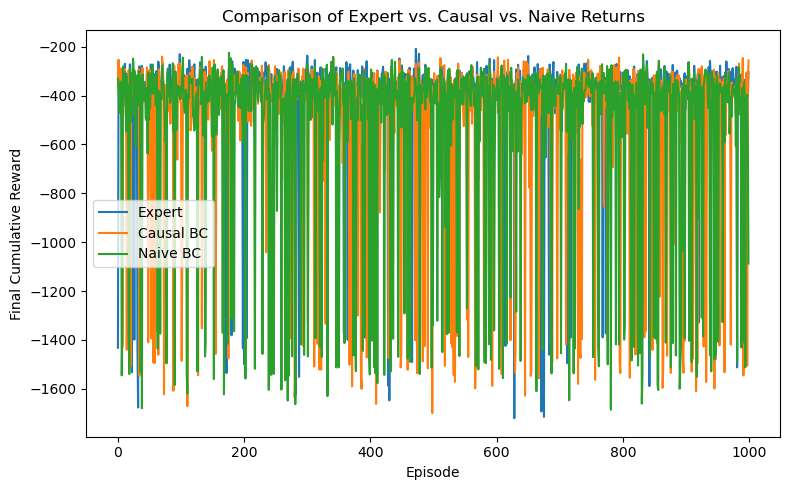

In [ ]:
expert_episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    expert_episode_rewards[ep] += float(rec['reward'])

num_eps = len(expert_episode_rewards)
expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

causal_records = collect_imitator_trajectories(
    env,
    causal_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

causal_episode_rewards = defaultdict(float)
for rec in causal_records:
    ep = rec['episode']
    causal_episode_rewards[ep] += float(rec['reward'])

causal_rewards = [causal_episode_rewards[e] for e in range(num_eps)]

naive_records = collect_imitator_trajectories(
    env,
    naive_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

naive_episode_rewards = defaultdict(float)
for rec in naive_records:
    ep = rec['episode']
    naive_episode_rewards[ep] += float(rec['reward'])

naive_rewards = [naive_episode_rewards[e] for e in range(num_eps)]

plt.figure(figsize=(8,5))
plt.plot(expert_rewards, label='Expert')
plt.plot(causal_rewards, label='Causal BC')
plt.plot(naive_rewards, label='Naive BC')
plt.xlabel('Episode')
plt.ylabel('Final Cumulative Reward')
plt.title('Comparison of Expert vs. Causal vs. Naive Returns')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
len(records), len(causal_records), len(naive_records)

(266363, 350713, 363025)

In [ ]:
sum(expert_rewards)/num_eps, sum(causal_rewards)/num_eps, sum(naive_rewards)/num_eps

(-395.590865752939, -522.3404865265243, -537.9125283717386)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

def get_episode_xy_from_records(records, episode_id: int):
    '''
    records: list of dicts from collect_expert_trajectories(...)
    episode_id: which episode to extract

    Returns:
        xs, ys : np.ndarray of shape (T,)
    '''
    # Filter records for that episode, sorted by step
    ep = [r for r in records if r['episode'] == episode_id]
    ep = sorted(ep, key=lambda r: r['step'])

    xs, ys = [], []
    for r in ep:
        # r['info']['hidden_obs']['P'] is a *history* list; last entry is current position
        pos = r['obs']['P'][-1]   # shape (3,)
        xs.append(pos[0])
        ys.append(pos[1])

    return np.array(xs), np.array(ys)

def plot_ant_trajectory_xy(records, episode_id: int = 0, ax=None, title_prefix='AntMaze'):
    '''
    Visualize the ant's 2D trajectory (x, y) for a single episode.

    - Path is colored by time (early=dark, late=bright).
    - Start and end are annotated.
    - Small arrows show direction every few steps.
    '''
    xs, ys = get_episode_xy_from_records(records, episode_id)
    T = len(xs)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Build a colored line collection for the path
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Time as color (0..1)
    t_norm = np.linspace(0, 1, T-1)
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
    lc.set_array(t_norm)
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    # Start and end markers
    ax.scatter(xs[0], xs[0], alpha=0)  # dummy to keep colors aligned if needed
    ax.scatter(xs[0], ys[0], s=80, c='green', marker='o', edgecolors='black', label='Start')
    ax.scatter(xs[-1], ys[-1], s=80, c='red', marker='X', edgecolors='black', label='End')

    # Small arrows every N steps to show direction
    step = max(1, T // 30)  # about ~30 arrows max
    for i in range(0, T-1, step):
        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        ax.arrow(xs[i], ys[i], dx, dy,
                 length_includes_head=True,
                 head_width=0.2,
                 head_length=0.4,
                 alpha=0.6)

    # Colorbar for time
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Time (normalized)')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_title(f'{title_prefix} - Episode {episode_id} trajectory')
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return fig, ax

In [ ]:
i = 0

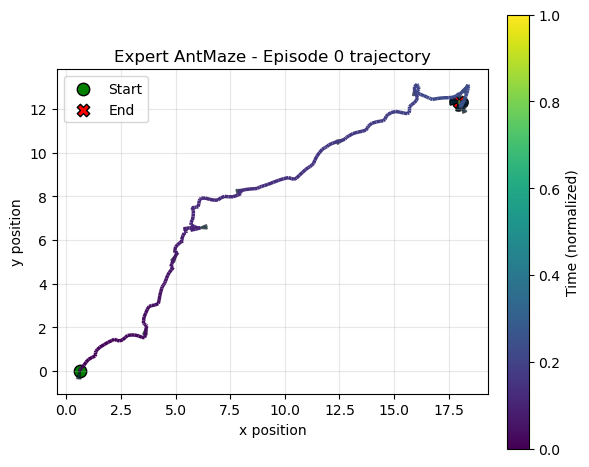

In [ ]:
fig, ax = plot_ant_trajectory_xy(records, episode_id=i % num_eps, title_prefix='Expert AntMaze')
plt.show()
i += 1

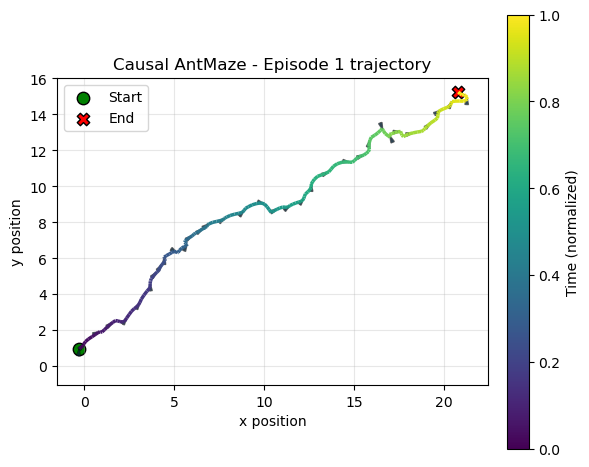

In [ ]:
fig, ax = plot_ant_trajectory_xy(causal_records, episode_id=i % num_eps, title_prefix='Causal AntMaze')
plt.show()
i += 1

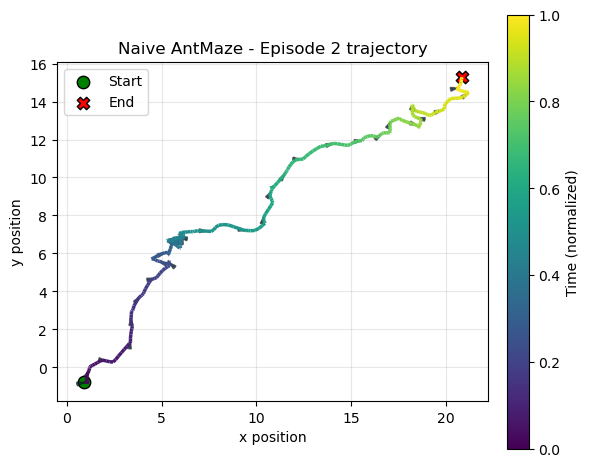

In [ ]:
fig, ax = plot_ant_trajectory_xy(naive_records, episode_id=i % num_eps, title_prefix='Naive AntMaze')
plt.show()
i += 1

=== W DIAGNOSTIC: ENV-LEVEL CHECK ===
Collected 1500 debug steps over 5 episodes.
Basic stats:
  ||U||: mean=0.339, std=0.341, min=0.000, max=0.999
  W    : mean=0.402, std=0.447, min=-0.412, max=0.996
  ||L||: mean=0.650, std=0.317, min=0.010, max=1.958
  Y    : mean=-1.665, std=0.669, min=-2.976, max=-1.000
Correlations (env-level):
  corr(W, ||U||) = 0.850
  corr(W, Y)     = -0.849
  corr(||U||, Y) = -1.000


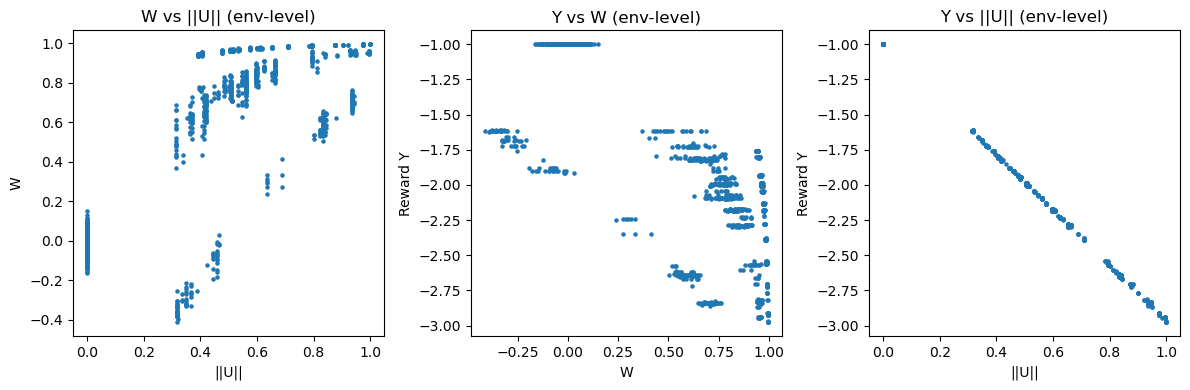


=== W DIAGNOSTIC: DATASET-LEVEL CHECK (records) ===
Detected observation key in records: obs
Extracted 266363 W values from records.
Correlations (records-level):
  corr(W, ||X||) = 0.002
  corr(W, Y)     = -0.828


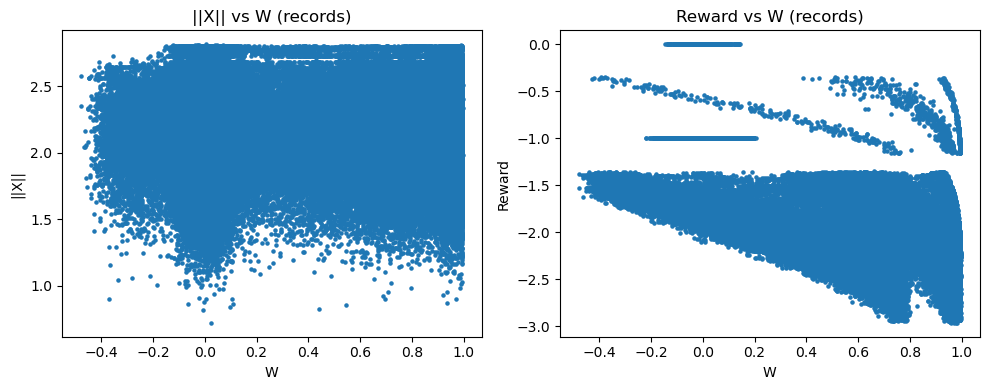


[Done] W diagnostics complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print("=== W DIAGNOSTIC: ENV-LEVEL CHECK ===")

# 1) ENV-LEVEL CHECK: is W actually responding to U and affecting reward?
debug_episodes = 5
max_debug_steps = min(num_steps, 300)

debug_env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed + 123)

U_norms, W_vals, L_norms, Y_vals = [], [], [], []

for ep in range(debug_episodes):
    obs, info = debug_env.reset(seed=seed + 123 + ep)
    terminated = False
    truncated = False
    t = 0

    while not (terminated or truncated) and t < max_debug_steps:
        # random action rollout just to probe the dynamics
        action = debug_env.env.action_space.sample()
        obs, reward, terminated, truncated, info = debug_env.env.step(
            action, history=True, show_reward=True
        )

        # pull latest values directly from SCM
        u = np.asarray(debug_env.env._U[-1], dtype=np.float64)
        w = float(debug_env.env.W[-1][0])
        l = float(np.linalg.norm(debug_env.env.L[-1]))
        y = float(debug_env.env._Y[-1])

        U_norms.append(float(np.linalg.norm(u)))
        W_vals.append(w)
        L_norms.append(l)
        Y_vals.append(y)

        t += 1

U_norms = np.asarray(U_norms)
W_vals = np.asarray(W_vals)
L_norms = np.asarray(L_norms)
Y_vals = np.asarray(Y_vals)

def safe_corr(x, y, name_x, name_y):
    if len(x) < 2 or np.allclose(np.var(x), 0) or np.allclose(np.var(y), 0):
        print(f"  [WARN] Not enough variation to compute correlation({name_x}, {name_y})")
        return np.nan
    return float(np.corrcoef(x, y)[0, 1])

print(f"Collected {len(U_norms)} debug steps over {debug_episodes} episodes.")
print("Basic stats:")
print(f"  ||U||: mean={U_norms.mean():.3f}, std={U_norms.std():.3f}, min={U_norms.min():.3f}, max={U_norms.max():.3f}")
print(f"  W    : mean={W_vals.mean():.3f}, std={W_vals.std():.3f}, min={W_vals.min():.3f}, max={W_vals.max():.3f}")
print(f"  ||L||: mean={L_norms.mean():.3f}, std={L_norms.std():.3f}, min={L_norms.min():.3f}, max={L_norms.max():.3f}")
print(f"  Y    : mean={Y_vals.mean():.3f}, std={Y_vals.std():.3f}, min={Y_vals.min():.3f}, max={Y_vals.max():.3f}")

corr_W_U = safe_corr(W_vals, U_norms, "W", "||U||")
corr_W_Y = safe_corr(W_vals, Y_vals, "W", "Y")
corr_U_Y = safe_corr(U_norms, Y_vals, "||U||", "Y")

print("Correlations (env-level):")
print(f"  corr(W, ||U||) = {corr_W_U:.3f}")
print(f"  corr(W, Y)     = {corr_W_Y:.3f}")
print(f"  corr(||U||, Y) = {corr_U_Y:.3f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(U_norms, W_vals, s=5)
plt.xlabel("||U||")
plt.ylabel("W")
plt.title("W vs ||U|| (env-level)")

plt.subplot(1, 3, 2)
plt.scatter(W_vals, Y_vals, s=5)
plt.xlabel("W")
plt.ylabel("Reward Y")
plt.title("Y vs W (env-level)")

plt.subplot(1, 3, 3)
plt.scatter(U_norms, Y_vals, s=5)
plt.xlabel("||U||")
plt.ylabel("Reward Y")
plt.title("Y vs ||U|| (env-level)")

plt.tight_layout()
plt.show()

print("\n=== W DIAGNOSTIC: DATASET-LEVEL CHECK (records) ===")

# 2) DATASET-LEVEL CHECK: is W present in expert records and correlated with X / Y?
# Try to infer observation key from the first record.
obs_key_candidates = ["obs", "observation", "state"]
obs_key = None
if len(records) > 0:
    sample_keys = list(records[0].keys())
    for k in obs_key_candidates:
        if k in sample_keys:
            obs_key = k
            break

print(f"Detected observation key in records: {obs_key}")
if obs_key is None:
    print("  [WARN] Could not find 'obs' / 'observation' / 'state' key in records; skipping dataset-level W check.")
else:
    Ws_rec, Xs_rec, Ys_rec = [], [], []

    for rec in records:
        obs = rec.get(obs_key, None)
        if obs is None or not isinstance(obs, dict):
            continue

        # W may be stored as a vector or history; handle both.
        if "W" not in obs:
            continue

        w_val = np.asarray(obs["W"])
        if w_val.ndim > 1:
            # assume (T,1) or (history,1) and take last step
            w_val = w_val[-1]
        Ws_rec.append(float(np.squeeze(w_val)))

        # X may be stored similarly; if present, we grab its norm
        if "X" in obs:
            x_val = np.asarray(obs["X"])
            if x_val.ndim > 1:
                x_val = x_val[-1]
            Xs_rec.append(float(np.linalg.norm(x_val)))
        else:
            Xs_rec.append(np.nan)

        # reward per record is already being used above
        Ys_rec.append(float(rec.get("reward", 0.0)))

    Ws_rec = np.asarray(Ws_rec, dtype=np.float64)
    Xs_rec = np.asarray(Xs_rec, dtype=np.float64)
    Ys_rec = np.asarray(Ys_rec, dtype=np.float64)

    print(f"Extracted {len(Ws_rec)} W values from records.")

    if len(Ws_rec) < 2:
        print("  [WARN] Not enough W values in records to compute correlations.")
    else:
        corr_W_X = safe_corr(Ws_rec[~np.isnan(Xs_rec)], Xs_rec[~np.isnan(Xs_rec)], "W", "||X||")
        corr_W_Y_rec = safe_corr(Ws_rec, Ys_rec, "W", "Y (records)")

        print("Correlations (records-level):")
        print(f"  corr(W, ||X||) = {corr_W_X:.3f}")
        print(f"  corr(W, Y)     = {corr_W_Y_rec:.3f}")

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.scatter(Ws_rec[~np.isnan(Xs_rec)], Xs_rec[~np.isnan(Xs_rec)], s=5)
        plt.xlabel("W")
        plt.ylabel("||X||")
        plt.title("||X|| vs W (records)")

        plt.subplot(1, 2, 2)
        plt.scatter(Ws_rec, Ys_rec, s=5)
        plt.xlabel("W")
        plt.ylabel("Reward")
        plt.title("Reward vs W (records)")

        plt.tight_layout()
        plt.show()

print("\n[Done] W diagnostics complete.")

=== W DIAGNOSTIC: ENV-LEVEL CHECK ===
Collected 1500 steps

Env-level stats:
  ||U|| mean=0.339, std=0.341
  W     mean=0.403, std=0.448
  Y     mean=-1.655, std=0.660

Env-level correlations:
  corr(W, ||U||) = 0.849
  corr(W, Y)     = -0.847
  corr(||U||, Y) = -1.000


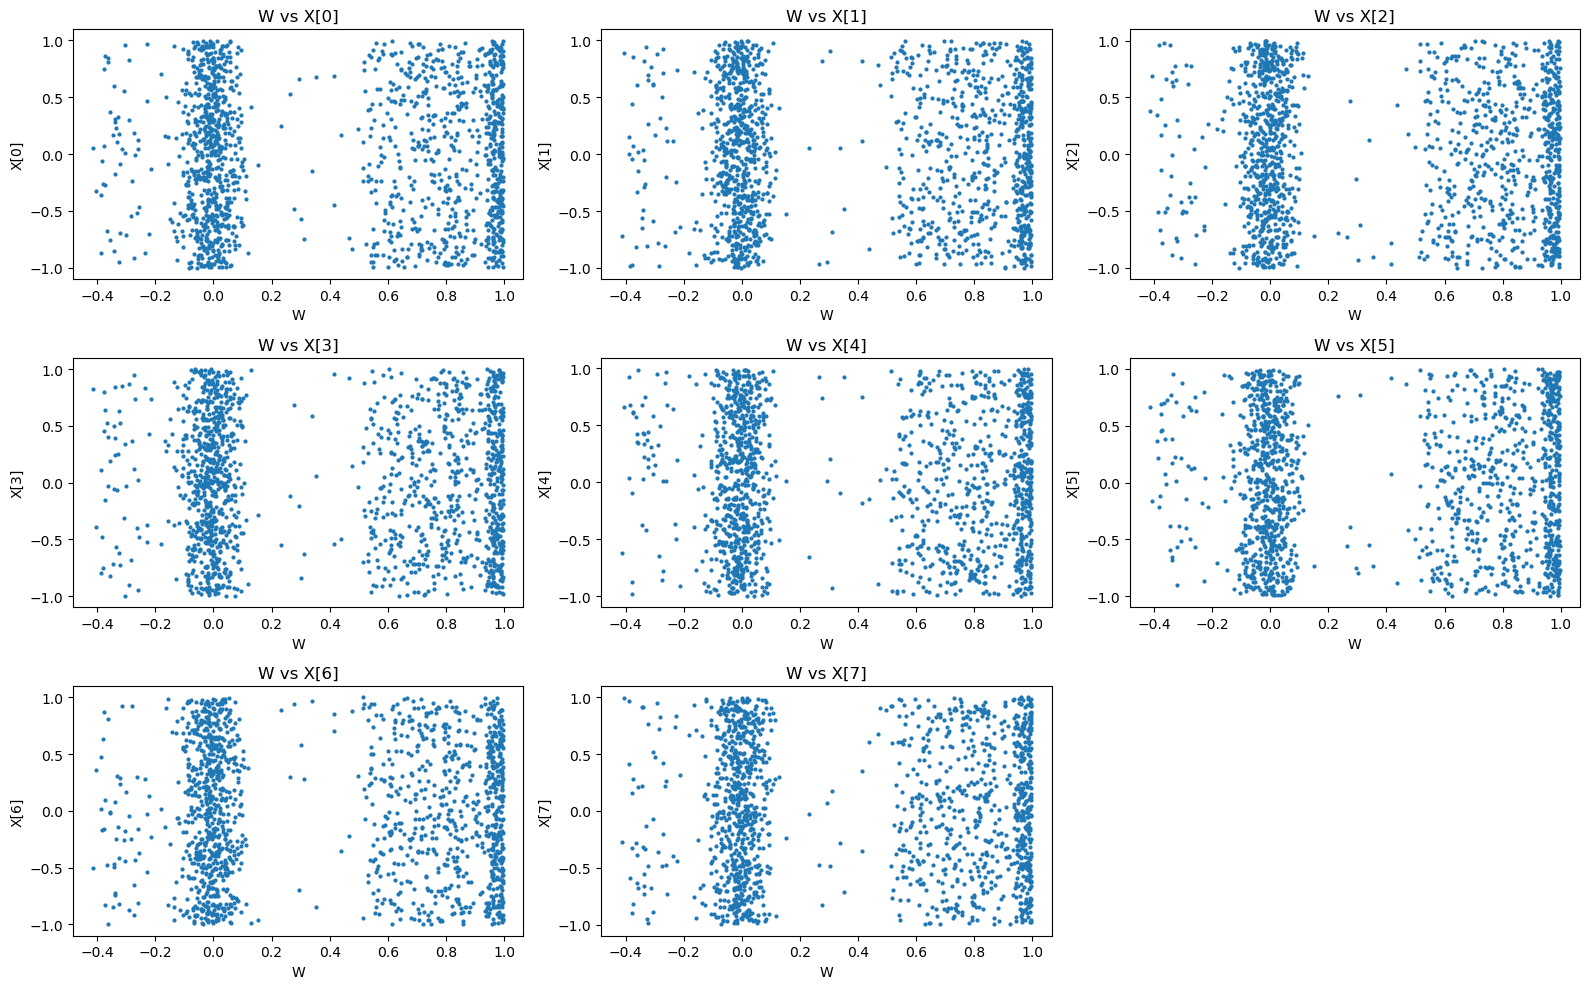


=== W DIAGNOSTIC: DATASET-LEVEL CHECK (records) ===
Detected observation key: obs
Extracted 266363 W values from records.

Dataset-level correlations:
  corr(W, Y) = -0.828
  corr(W, X[0]) = 0.009
  corr(W, X[1]) = -0.006
  corr(W, X[2]) = 0.002
  corr(W, X[3]) = -0.005
  corr(W, X[4]) = -0.007
  corr(W, X[5]) = -0.007
  corr(W, X[6]) = 0.002
  corr(W, X[7]) = -0.003


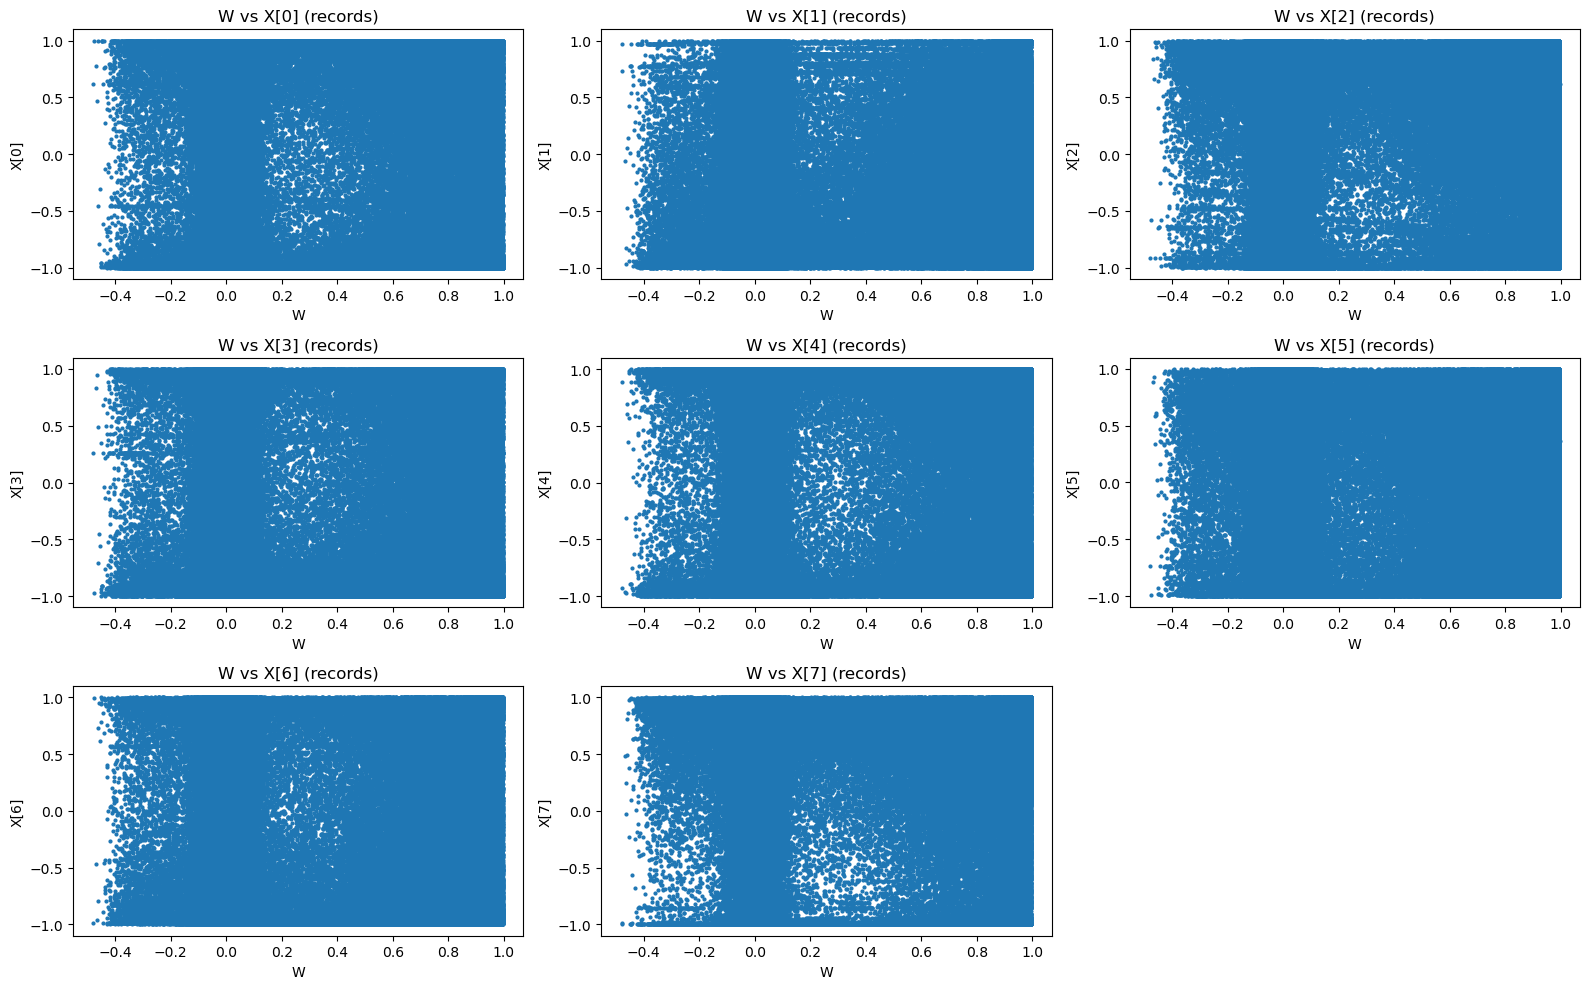


[Done] W diagnostics complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print("=== W DIAGNOSTIC: ENV-LEVEL CHECK ===")

# 1) ENV-LEVEL CHECK: test if W tracks U and affects Y
debug_episodes = 5
max_debug_steps = min(num_steps, 300)

debug_env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed + 123)

U_norms, W_vals, Y_vals = [], [], []
X_dims = [[] for _ in range(debug_env.env.action_space.shape[0])]  # 8 lists

for ep in range(debug_episodes):
    obs, info = debug_env.reset(seed=seed + 123 + ep)
    terminated = False
    truncated = False
    t = 0

    while not (terminated or truncated) and t < max_debug_steps:
        action = debug_env.env.action_space.sample()
        obs, reward, terminated, truncated, info = debug_env.env.step(
            action, history=True, show_reward=True
        )

        u = np.asarray(debug_env.env._U[-1], dtype=np.float64)
        w = float(debug_env.env.W[-1][0])
        y = float(debug_env.env._Y[-1])

        U_norms.append(float(np.linalg.norm(u)))
        W_vals.append(w)
        Y_vals.append(y)

        for k in range(len(X_dims)):
            X_dims[k].append(float(action[k]))

        t += 1

U_norms = np.asarray(U_norms)
W_vals  = np.asarray(W_vals)
Y_vals  = np.asarray(Y_vals)
X_dims  = [np.asarray(arr) for arr in X_dims]

def safe_corr(x, y):
    if len(x) < 3 or np.var(x) == 0 or np.var(y) == 0:
        return np.nan
    return float(np.corrcoef(x, y)[0, 1])

print(f"Collected {len(W_vals)} steps")

print("\nEnv-level stats:")
print(f"  ||U|| mean={U_norms.mean():.3f}, std={U_norms.std():.3f}")
print(f"  W     mean={W_vals.mean():.3f}, std={W_vals.std():.3f}")
print(f"  Y     mean={Y_vals.mean():.3f}, std={Y_vals.std():.3f}")

print("\nEnv-level correlations:")
print(f"  corr(W, ||U||) = {safe_corr(W_vals, U_norms):.3f}")
print(f"  corr(W, Y)     = {safe_corr(W_vals, Y_vals):.3f}")
print(f"  corr(||U||, Y) = {safe_corr(U_norms, Y_vals):.3f}")

# Plot W vs action dims
plt.figure(figsize=(16, 10))
for i in range(len(X_dims)):
    plt.subplot(3, 3, i+1)
    plt.scatter(W_vals, X_dims[i], s=4)
    plt.xlabel("W")
    plt.ylabel(f"X[{i}]")
    plt.title(f"W vs X[{i}]")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------

print("\n=== W DIAGNOSTIC: DATASET-LEVEL CHECK (records) ===")

# Attempt to identify observation key
obs_key_candidates = ["obs", "observation", "state"]
obs_key = None
if len(records) > 0:
    for k in obs_key_candidates:
        if k in records[0]:
            obs_key = k
            break

print(f"Detected observation key: {obs_key}")

if obs_key is None:
    print("  [WARN] Could not locate observation key in records — skipping dataset-level check.")
else:
    Ws_rec = []
    Ys_rec = []
    Xdims_rec = [[] for _ in range(env.env.action_space.shape[0])]

    for rec in records:
        obs = rec.get(obs_key, None)
        if obs is None or not isinstance(obs, dict):
            continue

        # W
        if "W" not in obs:
            continue
        wv = np.asarray(obs["W"])
        wv = wv[-1] if wv.ndim > 1 else wv
        Ws_rec.append(float(wv.squeeze()))

        # X
        if "X" in obs:
            xv = np.asarray(obs["X"])
            xv = xv[-1] if xv.ndim > 1 else xv
            for k in range(len(Xdims_rec)):
                Xdims_rec[k].append(float(xv[k]))
        else:
            for k in range(len(Xdims_rec)):
                Xdims_rec[k].append(np.nan)

        # Reward
        Ys_rec.append(float(rec.get("reward", 0.0)))

    Ws_rec = np.asarray(Ws_rec)
    Ys_rec = np.asarray(Ys_rec)
    Xdims_rec = [np.asarray(arr) for arr in Xdims_rec]

    print(f"Extracted {len(Ws_rec)} W values from records.")

    if len(Ws_rec) < 3:
        print("  [WARN] Not enough variation for dataset-level statistics.")
    else:
        print("\nDataset-level correlations:")

        print(f"  corr(W, Y) = {safe_corr(Ws_rec, Ys_rec):.3f}")
        for k in range(len(Xdims_rec)):
            mask = ~np.isnan(Xdims_rec[k])
            corr = safe_corr(Ws_rec[mask], Xdims_rec[k][mask])
            print(f"  corr(W, X[{k}]) = {corr:.3f}")

        # Plot W vs action dims in dataset
        plt.figure(figsize=(16, 10))
        for i in range(len(Xdims_rec)):
            plt.subplot(3, 3, i+1)
            plt.scatter(Ws_rec, Xdims_rec[i], s=4)
            plt.xlabel("W")
            plt.ylabel(f"X[{i}]")
            plt.title(f"W vs X[{i}] (records)")
        plt.tight_layout()
        plt.show()

print("\n[Done] W diagnostics complete.")

=== ACTION VARIATION UNDER W: NAIVE vs CAUSAL ===
Detected observation key (naive):  obs
Detected observation key (causal): obs


Naive:  extracted 363025 (W, X) pairs.
Causal: extracted 350713 (W, X) pairs.

Per-dimension correlations corr(W, X[d])
  dim 0: naive=-0.001, causal=0.006
  dim 1: naive=-0.007, causal=-0.011
  dim 2: naive=0.006, causal=-0.004
  dim 3: naive=-0.001, causal=-0.005
  dim 4: naive=-0.007, causal=-0.003
  dim 5: naive=-0.000, causal=-0.010
  dim 6: naive=0.007, causal=0.004
  dim 7: naive=0.001, causal=-0.009


/tmp/ipykernel_2087635/2759401822.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


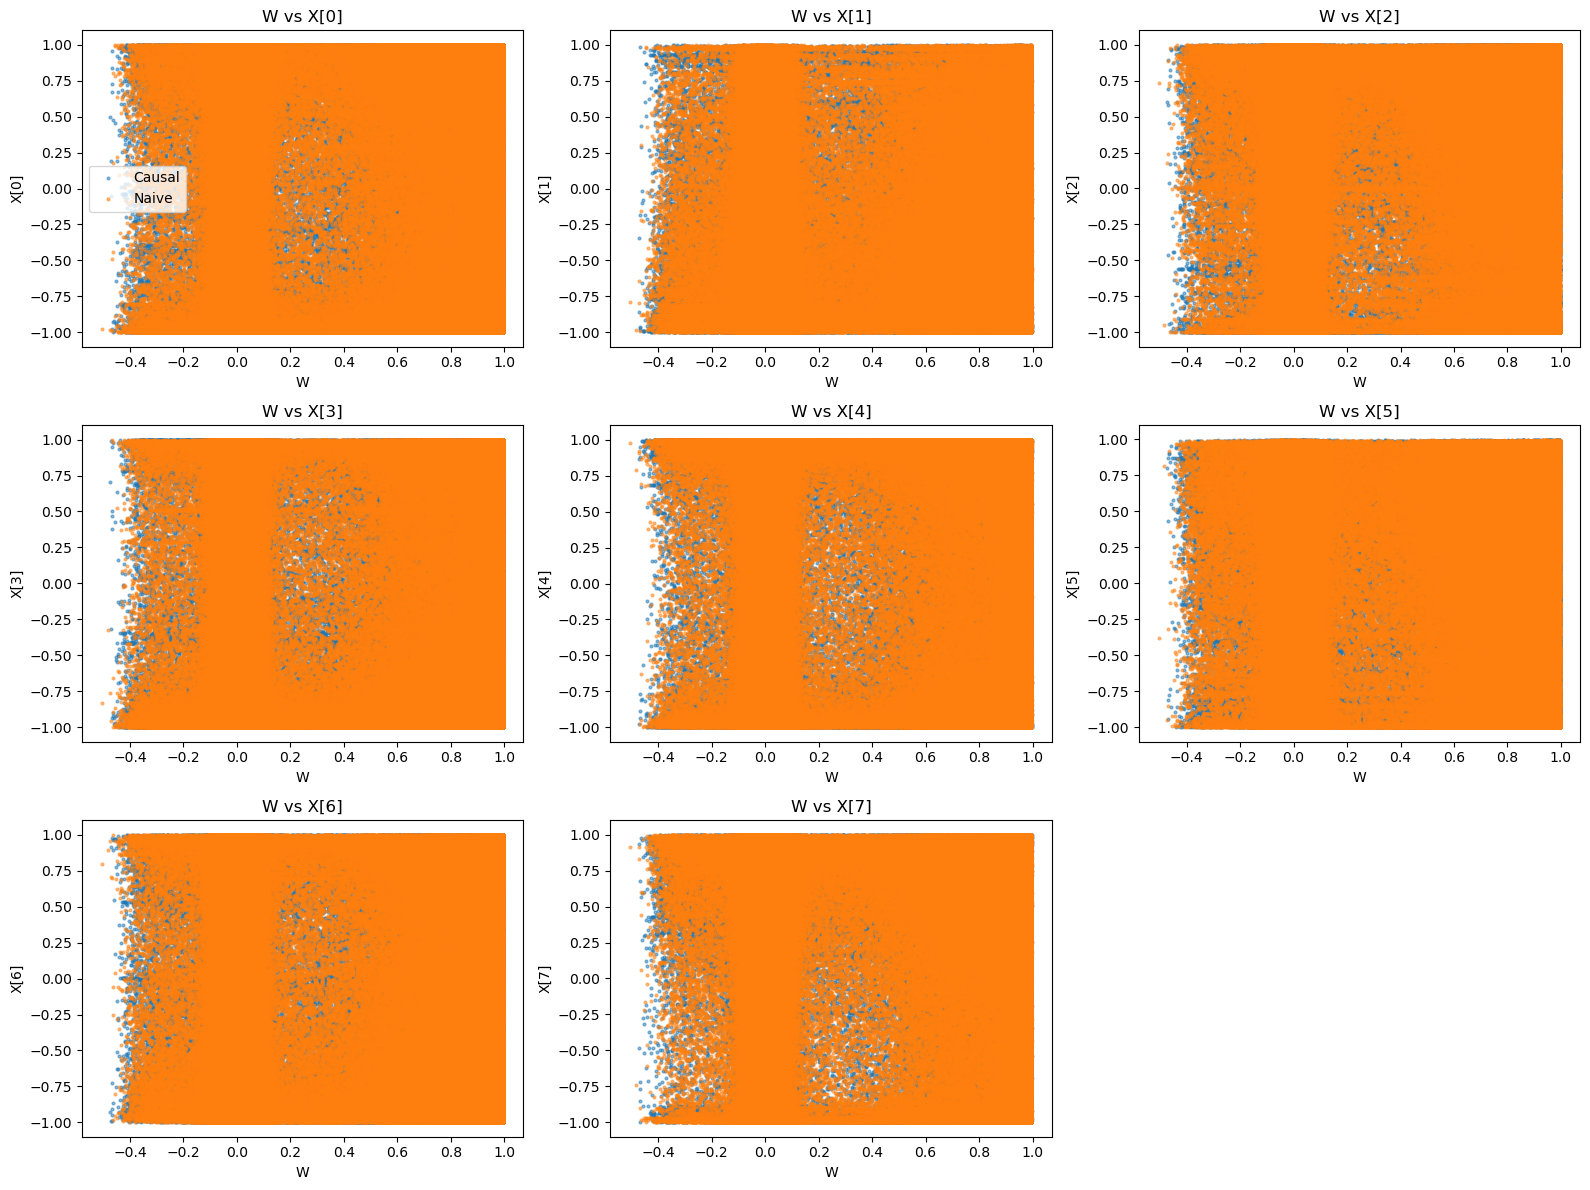


[Done] Action–W variation diagnostics complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print("=== ACTION VARIATION UNDER W: NAIVE vs CAUSAL ===")

def detect_obs_key(records):
    if not records:
        return None
    candidates = ["obs", "observation", "state"]
    keys = records[0].keys()
    for k in candidates:
        if k in keys:
            return k
    return None

obs_key_naive  = detect_obs_key(naive_records)
obs_key_causal = detect_obs_key(causal_records)
print(f"Detected observation key (naive):  {obs_key_naive}")
print(f"Detected observation key (causal): {obs_key_causal}")

if obs_key_naive is None or obs_key_causal is None:
    print("[WARN] Could not detect observation keys in naive/causal records.")
else:
    action_dim = env.env.action_space.shape[0]

    def extract_W_X(records, obs_key, action_dim):
        W_list = []
        X_lists = [[] for _ in range(action_dim)]

        for rec in records:
            obs = rec.get(obs_key, None)
            if obs is None or not isinstance(obs, dict):
                continue

            # W may be scalar or last element of history
            if "W" not in obs:
                continue
            wv = np.asarray(obs["W"])
            if wv.ndim > 1:
                wv = wv[-1]
            W_list.append(float(np.squeeze(wv)))

            # X may be vector or last element of history
            if "X" in obs:
                xv = np.asarray(obs["X"])
                if xv.ndim > 1:
                    xv = xv[-1]
                for k in range(action_dim):
                    X_lists[k].append(float(xv[k]))
            else:
                # if X missing, pad with NaNs to keep lengths aligned
                for k in range(action_dim):
                    X_lists[k].append(np.nan)

        W_arr = np.asarray(W_list, dtype=np.float64)
        X_arrs = [np.asarray(xs, dtype=np.float64) for xs in X_lists]
        return W_arr, X_arrs

    W_naive,  X_naive_dims  = extract_W_X(naive_records,  obs_key_naive,  action_dim)
    W_causal, X_causal_dims = extract_W_X(causal_records, obs_key_causal, action_dim)

    print(f"Naive:  extracted {len(W_naive)} (W, X) pairs.")
    print(f"Causal: extracted {len(W_causal)} (W, X) pairs.")

    def safe_corr(x, y):
        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]
        if len(x) < 3 or np.var(x) == 0 or np.var(y) == 0:
            return np.nan
        return float(np.corrcoef(x, y)[0, 1])

    # Per-dimension summary
    print("\nPer-dimension correlations corr(W, X[d])")
    for d in range(action_dim):
        corr_naive  = safe_corr(W_naive,  X_naive_dims[d])
        corr_causal = safe_corr(W_causal, X_causal_dims[d])
        print(f"  dim {d}: naive={corr_naive:.3f}, causal={corr_causal:.3f}")

    # Plots: W vs X[d], naive vs causal
    n_rows = int(np.ceil(action_dim / 3))
    plt.figure(figsize=(16, 4 * n_rows))

    for d in range(action_dim):
        plt.subplot(n_rows, 3, d + 1)

        # causal
        mask_c = ~np.isnan(X_causal_dims[d])
        plt.scatter(W_causal[mask_c], X_causal_dims[d][mask_c], s=4, alpha=0.5, label="Causal")

        # naive
        mask_n = ~np.isnan(X_naive_dims[d])
        plt.scatter(W_naive[mask_n], X_naive_dims[d][mask_n], s=4, alpha=0.5, label="Naive")

        plt.xlabel("W")
        plt.ylabel(f"X[{d}]")
        plt.title(f"W vs X[{d}]")
        if d == 0:
            plt.legend()

    plt.tight_layout()
    plt.show()

print("\n[Done] Action-W variation diagnostics complete.")